In [1]:
%matplotlib notebook
import torch
import numpy as np
from config import *
import Data.get_data_3 as _Data
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
import warnings
from utils import get_spx_pools, launch_cuda, load_checkpoint, ungroup_batches, iou_metrics
from utils import AverageMeter, merge_spx_label, FaissKNeighbors, FaissKMeans
import faiss.contrib.torch_utils
import Models.get_model_3 as _Models
from Data.augmentation import remove_small_objcts
warnings.filterwarnings("ignore")

config = set_config(jup_notebook=True, dataset='msra10k')
config.resume_model_path = '/media/marcelo/SSD/Py_all/lixo-rsync/logs_pinha/exp_pinha_msra10k_03/my_net_best.pth'
#config.resume_model_path = '/media/marcelo/SSD/Py_all/lixo-rsync/logs_sdumont/exp_sdumont_msra10k_ddp_n7/my_net_best.pth'
# path to the folder containing the dataset 
config.data_root = '../databases'
config.davis_config.train_batch_size = 1
config.davis_config.test_batch_size = 1
config.pre_computed_spx = False
config.return_1st_frame = False
config.davis_config.return_1st_frame = False
config.normalize = False
config.davis_config.normalize = False
if False:
    model, loss_fun = _Models.get_model_loss(config)
    model = launch_cuda(model)
    #model, _ = load_checkpoint(config, model)

    train_loader, test_loader = _Data.get_data(config)
    # comment the dataset slipt not used 
    #_iter = iter(train_loader)
    _iter = iter(test_loader)
    #knn = KNeighborsClassifier(n_neighbors = config.knn_neighbors)
    knn = FaissKNeighbors(k=config.knn_neighbors)
    kmeans = FaissKMeans()
    iou = AverageMeter()
    train_spx, test_spx = torch.tensor([]), torch.tensor([])
    train_spx, test_spx = train_spx.cuda(), test_spx.cuda()


def show_sample(b):
    with output:
        
        model.eval()    
        with torch.no_grad():

            img, spx, obj_label, num_obj, info = next(_iter)
            disp_img = img.clone()

            img = img.float().cuda()
            spx = spx.cuda()
            obj_label = obj_label.cuda()
            
            if info['frame_idx'].item() == 0:
                iou.reset()
                _, spx2label = get_spx_pools(spx, obj_label)
                spx[0][0] = merge_spx_label(spx[0][0], obj_label[0][0], spx2label[0,0])
                 
            spx_pools, _ = get_spx_pools(spx, obj_label)            
            super_feat = model(img, spx.float())
            spx_pools, super_feat = ungroup_batches(spx_pools, super_feat)
            
            for b in range(len(super_feat)):
            
                x = super_feat[b].clone().detach()#.cpu().numpy()
                y = spx_pools[b].clone().detach()#.cpu().numpy()
                idx = np.arange(1, y.shape[0]+1)
                
                if info['frame_idx'].item() == 0:
                    x_train, y_train, idx_train = x, y, idx
                    knn.fit(x_train,y_train)
                    kmeans.fit(x_train,y_train)
                else:
                    x_test, y_test, idx_test = x, y, idx
                    pred = knn.predict(x_test)                    
                    out_str = 'Img: {}, knn_score: {:^7.3f}'.format(info['name'][b], knn.score(x_test, y_test))
                    clus = kmeans.predict(x_test)
                    cent = kmeans.cluster_centers_
                    print('x_test: ', x_test.shape,' clusters:\n', clus.shape, 'centroids:\n', cent.shape)
                    
                aux_spx = spx[b][0] 
                global train_spx
                global test_spx
                
                if info['frame_idx'].item() == 0:
                    
                    train_spx = torch.zeros_like(aux_spx) +1
                    for n, i in enumerate(idx_train):    
                        train_spx[aux_spx==i] = y_train[n]
                    out_str = '\n Video: {}, Frame: {}/{} (knn fitting)'.format(info['name'][0],
                                                                   info['frame_idx'].item()+1,
                                                                   info['num_frames'].item())
                    plt.rcParams['figure.dpi'] = 200
                    plt.figure(num=0, figsize=(4.5, 4))
                    plt.subplot(2,2,1)
                    plt.axis('off')
                    plt.title('Frame', fontsize=6)
                    plt.imshow(disp_img[b].permute(1,2,0).cpu(), cmap='brg')                
                    plt.subplot(2,2,2)
                    plt.axis('off')
                    plt.title('Ground truth #{}'.format(obj_label[b,0].max()), fontsize=6)
                    plt.imshow(obj_label[b,0].cpu(), cmap='jet')
                    plt.subplot(2,2,3)
                    plt.axis('off')
                    plt.title('Spx #{}'.format(spx[b,0].max()), fontsize=6)
                    plt.imshow(spx[b,0].cpu(), cmap='jet')
                    plt.subplot(2,2,4)
                    plt.axis('off')
                    plt.title('spx train #{}'.format(train_spx.max().int()), fontsize=6)
                    plt.imshow(train_spx.cpu(), cmap='jet')
                    plt.suptitle(out_str, fontsize=6)
                    print()
                else:    
                    test_spx = torch.zeros_like(aux_spx) +1
                    for n, i in enumerate(idx_test):    
                        test_spx[aux_spx==i] = pred[n]
                
                    _iou = iou_metrics(obj_label[b,0].clone(), spx[b,0].clone(),
                                                            pred, [], [], idx_test)
                    iou.update(_iou.item())
                    
                    out_str += '\n IoU: {:^7.3f}'.format(iou.avg)
                    
                    out_str += '\n Video: {}, Frame: {}/{}'.format(info['name'][0],
                                                                   info['frame_idx'].item()+1,
                                                                   info['num_frames'].item())
                    plt.rcParams['figure.dpi'] = 200
                    plt.figure(num=0, figsize=(4.5, 4))
                    plt.subplot(2,2,1)
                    plt.axis('off')
                    plt.title('Frame', fontsize=6)
                    plt.imshow(disp_img[b].permute(1,2,0).cpu(), cmap='brg')                
                    plt.subplot(2,2,2)
                    plt.axis('off')
                    plt.title('Ground truth #{}'.format(obj_label[b,0].max()), fontsize=6)
                    plt.imshow(obj_label[b,0].cpu(), cmap='jet')
                    plt.subplot(2,2,3)
                    plt.axis('off')
                    plt.title('Spx #{}'.format(spx[b,0].max()), fontsize=6)
                    plt.imshow(spx[b,0].cpu(), cmap='jet')
                    plt.subplot(2,2,4)
                    plt.axis('off')
                    plt.title('spx test #{}'.format(test_spx.max().int()), fontsize=6)
                    plt.imshow(test_spx.cpu(), cmap='jet')
                    plt.suptitle(out_str, fontsize=6)
                    print()

button = widgets.Button(description="Next sample")
output = widgets.Output()
display(button, output)
button.on_click(show_sample)

Button(description='Next sample', style=ButtonStyle())

Output()

In [2]:
import seaborn as sns
import pandas as  pd
import numpy as np
import faiss


penguins = sns.load_dataset("penguins")
pen = penguins[['bill_length_mm','bill_depth_mm']].dropna()



In [3]:
kmeans = FaissKMeans(n_clusters=10)
kmeans2 = FaissKMeans(n_clusters=3)
datap = pen.to_numpy()
datap = np.ascontiguousarray(datap, dtype=np.float32)
print(datap.shape)
print(datap[0])

kmeans.fit(datap)
kmeans2.fit(datap)

print('\ncentroids: ',kmeans.cluster_centers_.shape,'\n', kmeans.cluster_centers_)

pen['Clusters'] = kmeans.labels_
pen['Classes'] = kmeans2.labels_
y = kmeans2.labels_
print('y: ', y.shape)
pen

(342, 2)
[39.1 18.7]

centroids:  (10, 2) 
 [[0.94291663 0.33295935]
 [0.927061   0.37485322]
 [0.9045262  0.426378  ]
 [0.9513904  0.30793673]
 [0.9353846  0.35358027]
 [0.9119607  0.4102563 ]
 [0.88031507 0.474132  ]
 [0.8947936  0.44642326]
 [0.95754313 0.28819436]
 [0.91823244 0.39600548]]
y:  (342, 1)


,bill_length_mm,bill_depth_mm,Clusters,Classes
0,39.1,18.7,2,2
1,39.5,17.4,9,2
2,40.3,18.0,5,2
4,36.7,19.3,6,2
5,39.3,20.6,6,2
...,...,...,...,...
338,47.2,13.7,8,1
340,46.8,14.3,8,1
341,50.4,15.7,8,1
342,45.2,14.8,3,1


In [4]:
pen['Clusters'].value_counts()

3    58
8    56
7    36
5    36
2    36
4    35
0    25
1    21
9    20
6    19
Name: Clusters, dtype: int64

In [5]:
pen['Classes'].value_counts()

2    134
1    123
0     85
Name: Classes, dtype: int64

In [6]:
pred  = kmeans.predict(datap)
np.set_printoptions(suppress=True)
print(pred[0].shape, type(pred))
print(np.concatenate((pred[0], pred[1]),axis=1))

(342, 1) <class 'tuple'>
[[0.00003159 2.        ]
 [0.00006032 9.        ]
 [0.00000715 5.        ]
 [0.00009799 6.        ]
 [0.00012636 6.        ]
 [0.00004101 5.        ]
 [0.00000083 7.        ]
 [0.00003684 6.        ]
 [0.0000608  2.        ]
 [0.00000453 5.        ]
 [0.00004184 5.        ]
 [0.00000656 9.        ]
 [0.00006723 6.        ]
 [0.00286865 6.        ]
 [0.00010228 7.        ]
 [0.00004089 7.        ]
 [0.00009084 7.        ]
 [0.00000823 6.        ]
 [0.00001073 2.        ]
 [0.00010765 2.        ]
 [0.00000548 7.        ]
 [0.00000858 6.        ]
 [0.00000381 2.        ]
 [0.00002992 5.        ]
 [0.0000062  6.        ]
 [0.00004697 5.        ]
 [0.00004327 5.        ]
 [0.0000428  7.        ]
 [0.00001502 2.        ]
 [0.00005162 9.        ]
 [0.00009894 7.        ]
 [0.00000048 5.        ]
 [0.00005805 2.        ]
 [0.00001287 2.        ]
 [0.00000012 6.        ]
 [0.00017345 7.        ]
 [0.00003576 9.        ]
 [0.00013125 7.        ]
 [0.00004828 2.        ]



centroids:  (10, 2) 
 [[0.94291663 0.33295935]
 [0.927061   0.37485322]
 [0.9045262  0.426378  ]
 [0.9513904  0.30793673]
 [0.9353846  0.35358027]
 [0.9119607  0.4102563 ]
 [0.88031507 0.474132  ]
 [0.8947936  0.44642326]
 [0.95754313 0.28819436]
 [0.91823244 0.39600548]]


<IPython.core.display.Javascript object>


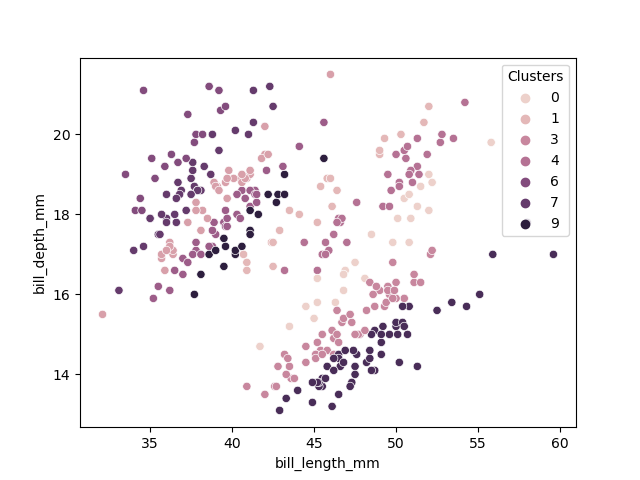

<AxesSubplot:xlabel='bill_length_mm', ylabel='bill_depth_mm'>

In [7]:
print('\ncentroids: ',kmeans.cluster_centers_.shape,'\n', kmeans.cluster_centers_)

sns.scatterplot(x="bill_length_mm", y="bill_depth_mm", hue = 'Clusters',  data=pen)


In [8]:
import torch.nn.functional as F

ndatap = datap.copy()
di = faiss.pairwise_distances(ndatap, kmeans.cluster_centers_)
print(di.shape)

di_sum = F.softmax(torch.from_numpy(1-di), dim = 1)

di3 = np.concatenate((pred[0], pred[1], di_sum),axis=1)

print(di_sum[:5])
print(di_sum[:1].sum())

#print('\n\nmin: ', di3.min(axis=0), 'max: ', di3.max(axis=0))

(342, 10)
tensor([[0.0782, 0.1084, 0.1278, 0.0595, 0.0938, 0.1251, 0.1149, 0.1264, 0.0460,
         0.1199],
        [0.0929, 0.1140, 0.1155, 0.0759, 0.1050, 0.1186, 0.0899, 0.1076, 0.0621,
         0.1185],
        [0.0902, 0.1135, 0.1180, 0.0725, 0.1032, 0.1203, 0.0936, 0.1108, 0.0585,
         0.1193],
        [0.0631, 0.0992, 0.1387, 0.0447, 0.0804, 0.1284, 0.1482, 0.1471, 0.0328,
         0.1174],
        [0.0612, 0.0989, 0.1405, 0.0425, 0.0792, 0.1298, 0.1499, 0.1494, 0.0306,
         0.1181]])
tensor(1.)


In [9]:
clus_memb = kmeans.get_cluster_members()
print(clus_memb)

[[335 212 186 325 189]
 [208 181 205 169 171]
 [ 50  63  59  22 145]
 [291 249 327 293 318]
 [203 192 180 211 155]
 [143  54  31 138  40]
 [ 34  85  24  17  21]
 [  6 136  47  79  48]
 [329 231 253 232 262]
 [ 74  64 109 114  98]]


In [10]:
print('clus_memb: ', clus_memb.shape)
print('y: ', y.shape)
ccc = y[clus_memb]
print('ccc: ', ccc.shape)

clus_memb:  (10, 5)
y:  (342, 1)
ccc:  (10, 5, 1)


In [11]:
votes = torch.from_numpy(y[clus_memb]).squeeze()
print(votes)
clus_classes = torch.mode(votes).values
print('\n')
print('clus_classes: ', clus_classes)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0]])


clus_classes:  tensor([0, 0, 2, 1, 0, 2, 2, 2, 1, 0])


In [12]:
print('clus_classes: ', clus_classes)
k=10 # max num of objects
soft_dist = torch.zeros_like(di_sum)
ctrl = clus_classes.clone()
for c in torch.unique(clus_classes):    
    idx = ctrl == c
    ctrl[clus_classes==c] = -1    
    soft_dist[:,c] = di_sum[:, idx].sum(dim=1)

soft_dist = soft_dist[:,:k]

print(soft_dist[:5])

print(di_sum.shape)
print(soft_dist.shape)

clus_classes:  tensor([0, 0, 2, 1, 0, 2, 2, 2, 1, 0])
tensor([[0.4003, 0.1055, 0.4942, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4304, 0.1380, 0.4316, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4263, 0.1311, 0.4426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3601, 0.0775, 0.5624, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3574, 0.0730, 0.5696, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])
torch.Size([342, 10])
torch.Size([342, 10])


In [13]:
ab = torch.tensor([[1, 2, 3, 4], [4, 5, 0, 1], [3, 4, 2, 1]])
print(ab, '\n')

ac = torch.zeros_like(ab) 

idx = torch.tensor([0, 2, 0, 1])
print(idx, '\n')

idx2 = idx.clone()

for c in torch.unique(idx):
    
    tt = idx2 == c
    idx2[idx==c] = -1
    ac[:,c] = ab[:,tt].sum(dim=1)
    
    print('c: ', c, ' -> ', tt, 'idx: ', idx)
    print(ac, '\n')

tensor([[1, 2, 3, 4],
        [4, 5, 0, 1],
        [3, 4, 2, 1]]) 

tensor([0, 2, 0, 1]) 

c:  tensor(0)  ->  tensor([ True, False,  True, False]) idx:  tensor([0, 2, 0, 1])
tensor([[4, 0, 0, 0],
        [4, 0, 0, 0],
        [5, 0, 0, 0]]) 

c:  tensor(1)  ->  tensor([False, False, False,  True]) idx:  tensor([0, 2, 0, 1])
tensor([[4, 4, 0, 0],
        [4, 1, 0, 0],
        [5, 1, 0, 0]]) 

c:  tensor(2)  ->  tensor([False,  True, False, False]) idx:  tensor([0, 2, 0, 1])
tensor([[4, 4, 2, 0],
        [4, 1, 5, 0],
        [5, 1, 4, 0]]) 



In [14]:
def get_spx(sz=19):
    spx = torch.zeros(1,sz,sz).int()
    cc = 1
    for i in range(sz):
        for j in range(sz):
            spx[0,i,j] = cc
            if cc<342:
                cc +=1
    
    spx1 = spx.clone()
    spx = torch.zeros(1,2*sz,2*sz).int()
    spx[:,0::2,:19] = spx1
    spx[:,1::2,:19] = spx1
    #spx[:,:,1::2] = spx[:,:,:19]
    spx1 = torch.zeros_like(spx)
    spx1[:,:,0::2] = spx[:,:,:19]
    spx1[:,:,1::2] = spx[:,:,:19]
    
    return spx1


In [15]:
import torch.nn as nn

class memoryClusterer(nn.Module):
    def __init__(self, config):
        super(memoryClusterer, self).__init__()
        
        self.n_clusters = config.kmeans_clusters
        self.n_neighbors = config.knn_neighbors
        
        self.knn = FaissKNeighbors(k=self.n_neighbors)
        self.kmeans = FaissKMeans(n_clusters=self.n_clusters)

        self.clus_classes = None
        self.num_votes = 3
        self.max_num_obj = config.max_num_obj
        
        self.X_mem = None
        self.y_mem = None
        self.init_mem_size = None
        self.max_mem_size = 650
        self.keep_init_mem = True
        
    
    def fit(self, X, y):
        
        self.knn.fit(X,y)        
        self.kmeans.fit(X)
        
        clus_memb = self.kmeans.get_cluster_members(self.num_votes) # indexes: [num_clusters, num_votes]        
        votes = y[clus_memb].squeeze() # votes: [num_clusters, num_votes]        
        self.clus_classes = torch.mode(votes).values # classes: [num_clusters]
        
        self.X_mem = X
        self.y_mem = y
        self.init_mem_size = y.shape[0]
    
    def predict(self, X, spx):
        
        clust_dist = faiss.pairwise_distances(X.numpy(), self.kmeans.cluster_centers_) # [X.shape[0], num_clusters]         
        clust_prob = F.softmax(torch.from_numpy(1-clust_dist), dim = 1) # probabiliy of X[n] belong to cluster[i]
        
        # sum up probabilities from clusters assigned to the same class
        class_prob = torch.zeros_like(clust_prob)
        ctrl = self.clus_classes.clone()
        for cls in torch.unique(self.clus_classes):    
            idx = ctrl == cls
            ctrl[self.clus_classes==cls] = -1    
            class_prob[:,cls] = clust_prob[:, idx].sum(dim=1)
        class_prob = class_prob[:,:self.max_num_obj,None] # n_clusters can be greater than max_num_obj
        
        knn_pred = self.knn.predict(X)
        
        # map predictions to superpixels coordinates
        c, w, h = spx.shape
        pre_seg = torch.zeros(c,w,h, dtype=spx.dtype) #deviceeeeeee
        prob_map = torch.zeros(self.max_num_obj, w, h)
        
        for i in range(spx.max()):            
            pre_seg[spx==i+1] = knn_pred[i]
            prob_map[:,spx[0]==i+1] = class_prob[i]#.unsqueeze(dim=1)
        
        return pre_seg, prob_map
    
    def update(self, X, y):
        
        # idexes for retrieving memory 
        new_mem_size = self.X_mem.shape[0] + X.shape[0]
        idx = [*range(new_mem_size)]        
        if (self.max_mem_size is not None) and (new_mem_size > self.max_mem_size):            
            if self.keep_init_mem:                
                idx = [*range(self.init_mem_size),
                       *range(self.init_mem_size+new_mem_size-self.max_mem_size, new_mem_size)]
            else:
                idx = [*range(new_mem_size-self.max_mem_size, new_mem_size)]    
            
        self.X_mem = torch.cat([self.X_mem, X], dim=0)[idx]
        self.y_mem = torch.cat([self.y_mem, y], dim=0)[idx]
        
        init_centroids = self.kmeans.cluster_centers_
        self.kmeans = FaissKMeans(n_clusters=self.n_clusters)
        self.kmeans.fit(self.X_mem, init_centroids=init_centroids)
        self.knn.fit(self.X_mem,self.y_mem)
           
        
my_mem = memoryClusterer(config)

my_X = torch.from_numpy(datap.copy())
my_y = torch.from_numpy(y.copy())
print('X: ', my_X.shape)
print('y: ', my_y.shape)

my_mem.fit(my_X, my_y)

print('classes: ', my_mem.clus_classes)

spx = get_spx()
print('\nspx: ', spx.shape)
my_X2 = torch.from_numpy(datap.copy())
my_y2 = torch.from_numpy(y.copy())
print('X2: ', my_X2.shape)
print('y2: ', my_y2.shape)

pre_seg, prob_map = my_mem.predict(my_X2, spx)

print('\n pre_seg: ', pre_seg.shape)
print('\n prob_map: ', prob_map.shape)

print('\nbefore update')
print('mem X: ', my_mem.X_mem.shape)
print('mem y: ', my_mem.y_mem.shape)
print('centroids: ', my_mem.kmeans.cluster_centers_)


print('\nafter update')
my_mem.update(my_X2, my_y2)
print('mem X: ', my_mem.X_mem.shape)
print('mem y: ', my_mem.y_mem.shape)
print('centroids: ', my_mem.kmeans.cluster_centers_)

X:  torch.Size([342, 2])
y:  torch.Size([342, 1])
classes:  tensor([0, 0, 2, 1, 0, 2, 2, 2, 1, 0])

spx:  torch.Size([1, 38, 38])
X2:  torch.Size([342, 2])
y2:  torch.Size([342, 1])

 pre_seg:  torch.Size([1, 38, 38])

 prob_map:  torch.Size([6, 38, 38])

before update
mem X:  torch.Size([342, 2])
mem y:  torch.Size([342, 1])
centroids:  [[0.94291663 0.33295935]
 [0.927061   0.37485322]
 [0.9045262  0.426378  ]
 [0.9513904  0.30793673]
 [0.9353846  0.35358027]
 [0.9119607  0.4102563 ]
 [0.88031507 0.474132  ]
 [0.8947936  0.44642326]
 [0.95754313 0.28819436]
 [0.91823244 0.39600548]]

after update
mem X:  torch.Size([650, 2])
mem y:  torch.Size([650, 1])
centroids:  [[0.94291663 0.33295932]
 [0.92748815 0.37380707]
 [0.90457606 0.42627272]
 [0.95139015 0.30793673]
 [0.9353846  0.35358033]
 [0.912516   0.40901318]
 [0.88074845 0.47337162]
 [0.8944918  0.4470288 ]
 [0.9575432  0.28819448]
 [0.91986144 0.39221898]]


<IPython.core.display.Javascript object>


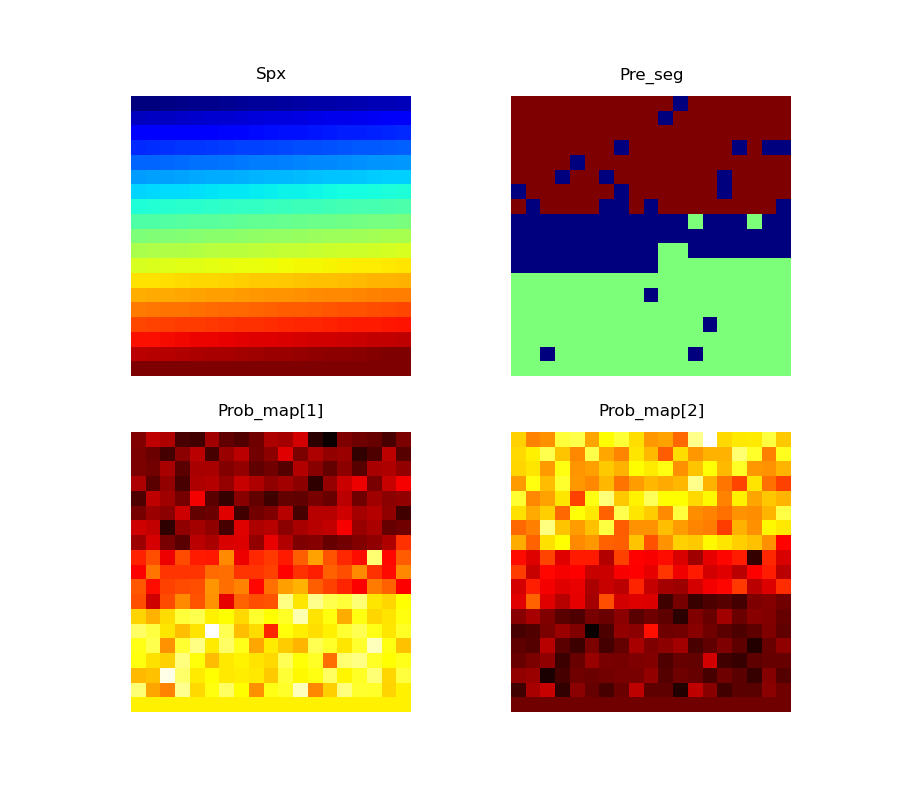

In [16]:
plt.rcParams['figure.dpi'] = 200
plt.figure(num=0, figsize=(4.5, 4))
plt.subplot(2,2,1)
plt.axis('off')
plt.title('Spx', fontsize=6)
plt.imshow(spx[0], cmap='jet')                
plt.subplot(2,2,2)
plt.axis('off')
plt.title('Pre_seg', fontsize=6)
plt.imshow(pre_seg[0], cmap='jet')
plt.subplot(2,2,3)
plt.axis('off')
plt.title('Prob_map[1]', fontsize=6)
plt.imshow(prob_map[1], cmap='hot')
plt.subplot(2,2,4)
plt.axis('off')
plt.title('Prob_map[2]', fontsize=6)
plt.imshow(prob_map[2], cmap='hot')

In [17]:
input_torch = torch.randn((1, 3, 2, 5), requires_grad=True)

target = np.array([[[1, 1, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1]],    
                    [[0, 0, 0, 0, 0], [1, 1, 1, 0, 0], [1, 0, 0, 0, 0]],
                    [[0, 0, 0, 1, 1], [0, 0, 0, 1, 1], [0, 0, 0, 0, 0]]])

target_argmax = np.array([np.argmax(a, axis = 0) for a in target])
target_torch = torch.tensor(target_argmax)

print(input_torch.requires_grad)
print('\n',target_torch)

in2 = input_torch.detach().clone()

print(in2.requires_grad)
print(input_torch.requires_grad)


True

 tensor([[0, 0, 0, 0, 2],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0]])
False
True


In [18]:
xt = np.array([[1,2,3,4],[3,6,9,12]])
print(xt)
print(xt.shape)
print('\n')

xz = np.repeat(xt, 3, axis=0)
print(xz)
print(xz.shape)
print('\n')

xw = np.tile(xt, (3, 1))
print(xw)
print(xw.shape)
print('\n')

xg = np.pad(xt, ((0,3),(0,0)), 'mean')
print(xg)
print(xg.shape)
print('\n')

print(np.ceil((3+6)/2))

[[ 1  2  3  4]
 [ 3  6  9 12]]
(2, 4)


[[ 1  2  3  4]
 [ 1  2  3  4]
 [ 1  2  3  4]
 [ 3  6  9 12]
 [ 3  6  9 12]
 [ 3  6  9 12]]
(6, 4)


[[ 1  2  3  4]
 [ 3  6  9 12]
 [ 1  2  3  4]
 [ 3  6  9 12]
 [ 1  2  3  4]
 [ 3  6  9 12]]
(6, 4)


[[ 1  2  3  4]
 [ 3  6  9 12]
 [ 2  4  6  8]
 [ 2  4  6  8]
 [ 2  4  6  8]]
(5, 4)


5.0


In [71]:
mu = torch.ones(2,2,5,5)
mu[0,1] = 2
mu[1,0] = 10
mu[1,1] = 20
print(mu.shape,'\n',mu,'\n')


ma = torch.ones(1,2,5,5)*2
ma[:,1] = 5
ma[:,0,1:4,1:4] = 3

ma[:,1,1:4,1:4] = 8
print('\n', ma.shape,'\n',ma)


mc = ma.view(-1,1,5,5) * mu
print('\n',mc.shape,'\n', mc)


torch.Size([2, 2, 5, 5]) 
 tensor([[[[ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.]],

         [[ 2.,  2.,  2.,  2.,  2.],
          [ 2.,  2.,  2.,  2.,  2.],
          [ 2.,  2.,  2.,  2.,  2.],
          [ 2.,  2.,  2.,  2.,  2.],
          [ 2.,  2.,  2.,  2.,  2.]]],


        [[[10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10.]],

         [[20., 20., 20., 20., 20.],
          [20., 20., 20., 20., 20.],
          [20., 20., 20., 20., 20.],
          [20., 20., 20., 20., 20.],
          [20., 20., 20., 20., 20.]]]]) 


 torch.Size([1, 2, 5, 5]) 
 tensor([[[[2., 2., 2., 2., 2.],
          [2., 3., 3., 3., 2.],
          [2., 3., 3., 3., 2.],
          [2., 3., 3., 3., 2.],
          [2., 2., 2., 2., 2.]],

         [[5., 5., 5., 5., 5.

In [54]:
A = torch.randn([12, 9, 64])
print('A: ', A.shape)
print('\n')

B = torch.randn([12, 9, 64])
print('B: ', B.shape)
print('\n')

A = A.unsqueeze(2)
print('A.unsqueeze(2): ', A.shape)
print('\n')

A = A.expand(-1, -1, 9, -1)
print('A.expand(-1, -1, 9, -1): ', A.shape)
print('\n')

B = B.unsqueeze(1)
print('B.unsqueeze(1): ', B.shape)
print('\n')

B = B.expand(-1, 9, -1, -1)
print('B.expand(-1, 9, -1, -1): ', B.shape)
print('\n')

D = torch.cat([A,B], dim=-1)
print('D.cat[A,B] dim=-1: ', D.shape)
print('\n')

D = D.view(12, 81, 128)
print('D.view(12, 81, 128): ', D.shape)
print('\n')



A:  torch.Size([12, 9, 64])


B:  torch.Size([12, 9, 64])


A.unsqueeze(2):  torch.Size([12, 9, 1, 64])


A.expand(-1, -1, 9, -1):  torch.Size([12, 9, 9, 64])


B.unsqueeze(1):  torch.Size([12, 1, 9, 64])


B.expand(-1, 9, -1, -1):  torch.Size([12, 9, 9, 64])


D.cat[A,B] dim=-1:  torch.Size([12, 9, 9, 128])


D.view(12, 81, 128):  torch.Size([12, 81, 128])




In [120]:
sf = torch.tensor([[1,2,3],[3,5,6],[7,8,9],[10,11,13],[13,14,15]])
#sf = sf.unsqueeze(0)
print(sf)
print(sf.shape)
print('\n')

mp = torch.tensor([[1, 0],[1,0],[1,1],[0,1],[0,1]])
mp = mp.unsqueeze(2)
mp = mp.permute(1,0).unsqueeze(2)
print(mp)
print(mp.shape)
print('\n')

mm = mp * sf
print(mm)
print(mm.shape)
print('\n')



tensor([[ 1,  2,  3],
        [ 3,  5,  6],
        [ 7,  8,  9],
        [10, 11, 13],
        [13, 14, 15]])
torch.Size([5, 3])


tensor([[[1],
         [1],
         [1],
         [0],
         [0]],

        [[0],
         [0],
         [1],
         [1],
         [1]]])
torch.Size([2, 5, 1])


tensor([[[ 1,  2,  3],
         [ 3,  5,  6],
         [ 7,  8,  9],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 7,  8,  9],
         [10, 11, 13],
         [13, 14, 15]]])
torch.Size([2, 5, 3])




In [148]:
sf = torch.tensor([[1,2,3],[3,5,6],[7,8,9],[10,11,13],[13,14,15]])
sf = sf.unsqueeze(0)
sf = torch.cat([sf, sf+15], dim=0).unsqueeze(0)
print(sf)
print(sf.shape)
print('\n')

mp = torch.tensor([[[1,1,1],[1,1,1],[1,1,1],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0],[1,1,1],[1,1,1]]])
print(mp.shape)
mp = mp.unsqueeze(1)
print(mp)
print(mp.shape)
print('\n')

mm = mp * sf
print(mm[0])
print('\n')
print(mm[1])
print(mm.shape)

tensor([[[[ 1,  2,  3],
          [ 3,  5,  6],
          [ 7,  8,  9],
          [10, 11, 13],
          [13, 14, 15]],

         [[16, 17, 18],
          [18, 20, 21],
          [22, 23, 24],
          [25, 26, 28],
          [28, 29, 30]]]])
torch.Size([1, 2, 5, 3])


torch.Size([2, 5, 3])
tensor([[[[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [1, 1, 1],
          [1, 1, 1]]]])
torch.Size([2, 1, 5, 3])


tensor([[[ 1,  2,  3],
         [ 3,  5,  6],
         [ 7,  8,  9],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[16, 17, 18],
         [18, 20, 21],
         [22, 23, 24],
         [ 0,  0,  0],
         [ 0,  0,  0]]])


tensor([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [10, 11, 13],
         [13, 14, 15]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [25, 26, 28],
         [28, 29,